# Image (pre)processing

Based on material taken from the Kadenze course [Creative applications of deep learning with tensorflow](https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow-i)

# Outline

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Utility functions](#Utility-functions)
- [Playing with images](#Playing-with-images)
  - [Load , crop and resize](#Load-Crop-Resize)
  - [Compute mean and std](#Compute-mean)
  - [Histogram processing and image normalization](#Histogram-processing)
- [Playing with images witn tensorflow](#Playing-with-images-tensorflow")
  - [Create montage](#Create-montage)
  - [Compute mean std and normalize](#Compute-mean-tensorflow)
  - [Convolve images](#Convolve-tensorflow)
  - [sort images](#Sort-tensorflow)
 

<!-- /MarkdownTOC -->

In [1]:
import os
from scipy.misc import imresize
import scipy

from PIL import Image
from skimage.transform import resize
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

image_dir = './images'

In [2]:
# Bit of formatting because inline code is not styled very good by default:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="Utility-functions"></a>
## Utility functions

In [3]:
def imcrop_tosquare(img):
    """Make any image a square image.

    Parameters
    ----------
    img : np.ndarray
        Input image to crop, assumed at least 2d.

    Returns
    -------
    crop : np.ndarray
        Cropped image.
    """
    if img.shape[0] > img.shape[1]:
        extra = (img.shape[0] - img.shape[1])
        if extra % 2 == 0:
            crop = img[extra // 2:-extra // 2, :]
        else:
            crop = img[max(0, extra // 2 - 1):min(-1, -extra // 2), :]
    elif img.shape[1] > img.shape[0]:
        extra = (img.shape[1] - img.shape[0])
        if extra % 2 == 0:
            crop = img[:, extra // 2:-extra // 2]
        else:
            crop = img[:, max(0, extra // 2 - 1):min(-1, -extra // 2)]
    else:
        crop = img
    return crop

def imcrop(img, amt):
    if amt <= 0:
        return img
    row_i = int(img.shape[0] * amt) // 2
    col_i = int(img.shape[1] * amt) // 2
    return img[row_i:-row_i, col_i:-col_i]

def montage(images, saveto='montage.png'):
    """Draw all images as a montage separated by 1 pixel borders.
    Also saves the file to the destination specified by `saveto`.
    Parameters
    ----------
    images : numpy.ndarray
        Input array to create montage of.  Array should be:
        batch x height x width x channels.
    saveto : str
        Location to save the resulting montage image.
    Returns
    -------
    m : numpy.ndarray
        Montage image.
    """
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    else:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    plt.imsave(arr=m, fname=saveto)
    return m



<a name="Playing-with-images"></a>
# Playing with images 


<a name="Load-Crop-Resize"></a>
## Load, crop and resize images

In [5]:
image_dir = './celebs'
n_images  = 10
files = [file_i
         for file_i in os.listdir(image_dir)
         if file_i.endswith('.jpg') or file_i.endswith('.JPG') ][:n_images]

imgs = []
for file_i in files:
    f_in = os.path.join(image_dir,file_i)
    img = plt.imread(f_in)
    square = imcrop_tosquare(img)
    crop = imcrop(square, 0.2)
    rsz = imresize(crop, (64, 64))
    imgs.append(rsz)

print 'Aggregating all images to batch structure\n---------------------------------------------'
data = np.array(imgs)
print 'Method 1: Processing {} images. Shape of aggregated image is {}'.format(len(imgs),data.shape)

data = np.concatenate([img_i[np.newaxis] for img_i in imgs], axis=0)
print 'Methon 2: Shape of concatinated image is  {}'.format(data.shape)



Aggregating all images to batch structure
---------------------------------------------
Method 1: Processing 10 images. Shape of aggregated image is (10, 64, 64, 3)
Methon 2: Shape of concatinated image is  (10, 64, 64, 3)


Image shape: (64, 64, 3). Image type: uint8


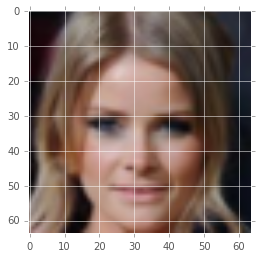

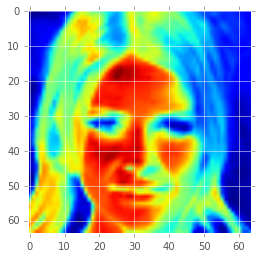

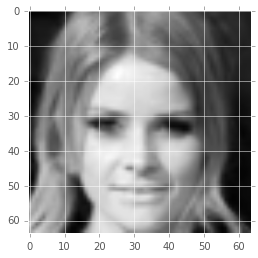

In [6]:
#f_in = full_fnames[np.random.randint(0, len(files))]
img  = imgs[np.random.randint(0, len(imgs))]
print 'Image shape: {}. Image type: {}'.format(img.shape,img.dtype)

plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(img[:, :, 0])
plt.figure()
plt.imshow(img[:, :, 0], cmap='gray')

<a name="Compute-mean"></a>
## Compute mean and std

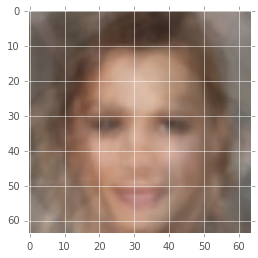

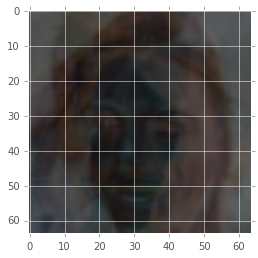

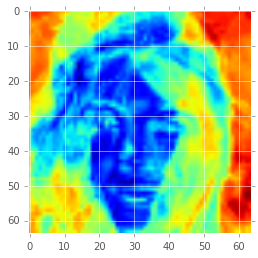

In [7]:
mean_img = np.mean(data, axis=0)
plt.figure()
plt.imshow(mean_img.astype(np.uint8))

# Variance form each color channel represented as single color image
# Vakue 255 --> white , 0 --> black, So th ebright parts are where the
# large variance in the image is
std_img = np.std(data, axis=0)
plt.figure()
plt.imshow(std_img.astype(np.uint8))

# Mean variance as heat map. 
# more red --> higher variance
# more blue ==> lower variance
plt.figure()
plt.imshow(np.mean(std_img, axis=2).astype(np.uint8))

<a name="Histogram-processing"></a>

# Histogram processing

Shape of flattened images    :  (122880,)
Shape of flattened mean image:  (12288,)


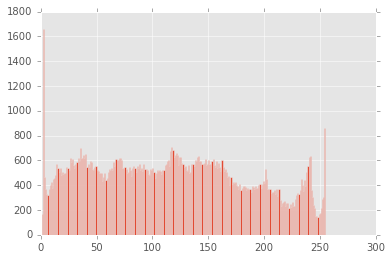

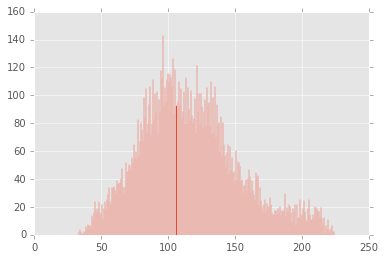

In [8]:
flattened = data.ravel()
print 'Shape of flattened images    : ',flattened.shape
print 'Shape of flattened mean image: ',mean_img.ravel().shape
plt.figure()
h      = plt.hist(flattened.ravel(), 255)
plt.figure()
h_mean = plt.hist(mean_img.ravel(), 255)

## Substraction of the mean

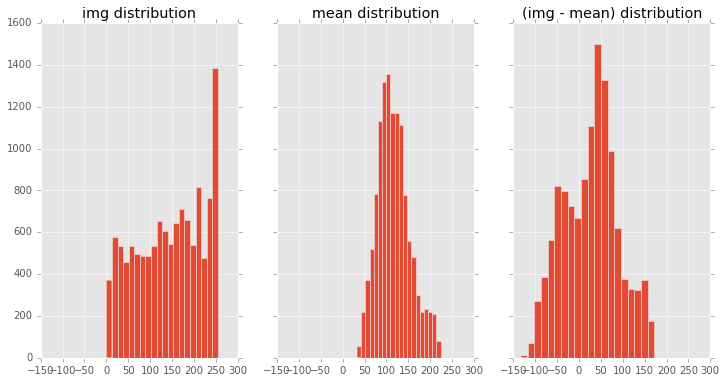

In [9]:
bins = 20
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axs[0].hist((data[0]).ravel(), bins)
axs[0].set_title('img distribution')
axs[1].hist((mean_img).ravel(), bins)
axs[1].set_title('mean distribution')
axs[2].hist((data[0] - mean_img).ravel(), bins)
axs[2].set_title('(img - mean) distribution')

## Normalization - divide by std

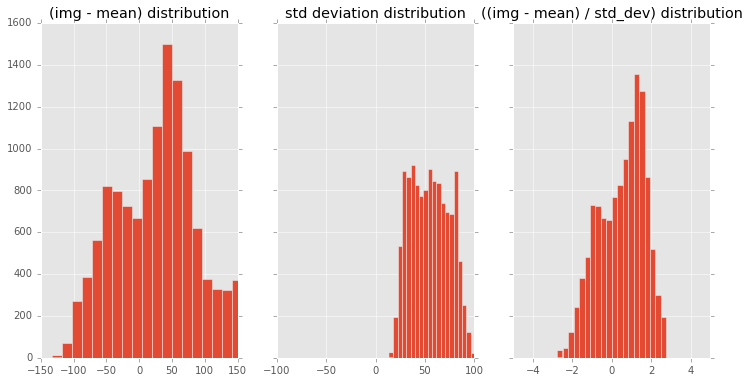

In [10]:
bins = 20
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

axs[0].set_xlim([-150, 150])
axs[0].hist((data[0] - mean_img).ravel(), bins)
axs[0].set_title('(img - mean) distribution')

axs[1].set_xlim([-100, 100])
axs[1].hist((std_img).ravel(), bins)
axs[1].set_title('std deviation distribution')

axs[2].set_xlim([-5, 5])
axs[2].hist(((data[0] - mean_img) / std_img).ravel(), bins)
axs[2].set_title('((img - mean) / std_dev) distribution')

<a name="Playing-with-images-tensorflow"></a>
# Playing with images in tensorflow


## Load images

In [18]:
# Get exactly 100 pictures
image_dir = './images'
n_images  = 100
files = [file_i
         for file_i in os.listdir(image_dir)
         if file_i.endswith('.jpg') or file_i.endswith('.JPG') ][:n_images]
assert(len(files) == n_images)

full_fnames  = [os.path.join(image_dir,f) for f in files]
imgs_orig    = [plt.imread(f)[...,:3] for f in full_fnames]  # Read every file as RBG
sqr_imgs     = [imcrop_tosquare(i) for i in imgs_orig]       # Convert to a square image
imgs_resized = [resize(i,(100,100)) for i in sqr_imgs]       # Resize to 100 x 100
imgs         = np.array(imgs_resized).astype(np.float32)     # convert to 4D image

print 'Aggregating all images to batch structure\n---------------------------------------------'
print 'Processing {} images. Shape of aggregated image is {}'.format(len(imgs_orig),imgs.shape)


Aggregating all images to batch structure
---------------------------------------------
Processing 100 images. Shape of aggregated image is (100, 100, 100, 3)


<a name="Create-montage"></a>
## Create montage

(100, 100, 100, 3)


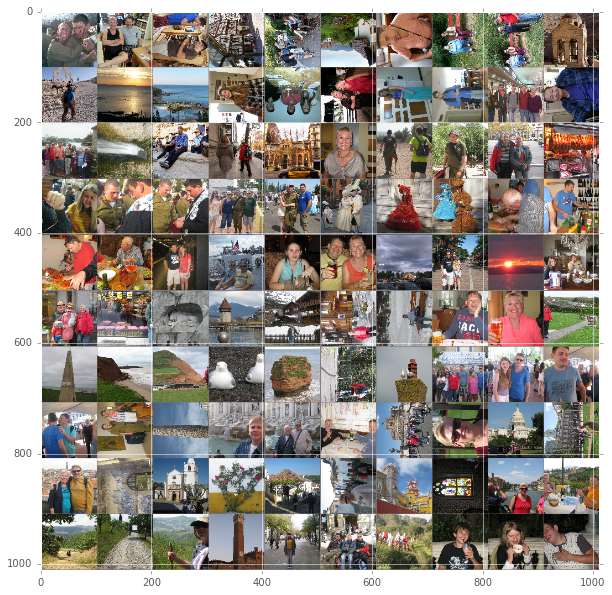

In [19]:
# Create montage out of the 100 images
print imgs.shape
assert(imgs.shape == (100, 100, 100, 3))
plt.figure(figsize=(10, 10))
plt.imshow(montage(imgs, saveto='dataset.png'))

<a name="Compute-mean-tensorflow"></a>
## Compute mean and std with tensorflow

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7ffe9c062750>> ignored


Shape of mean image:  (100, 100, 3)
Shape of std image:  (100, 100, 3)
Shape of normalized  images:  (100, 100, 100, 3)


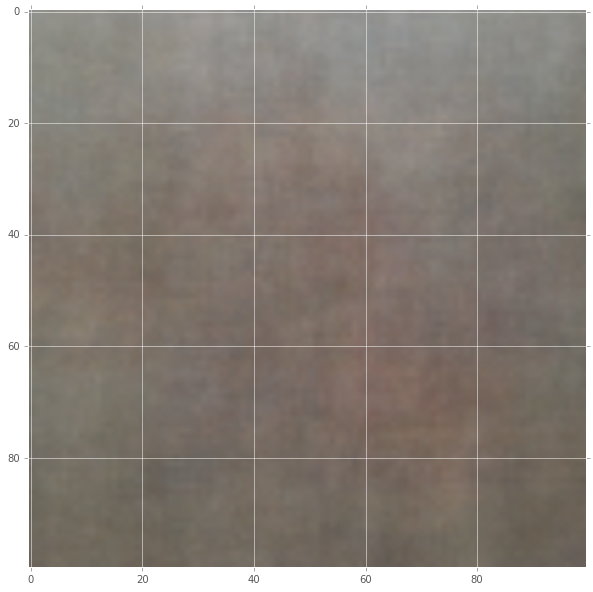

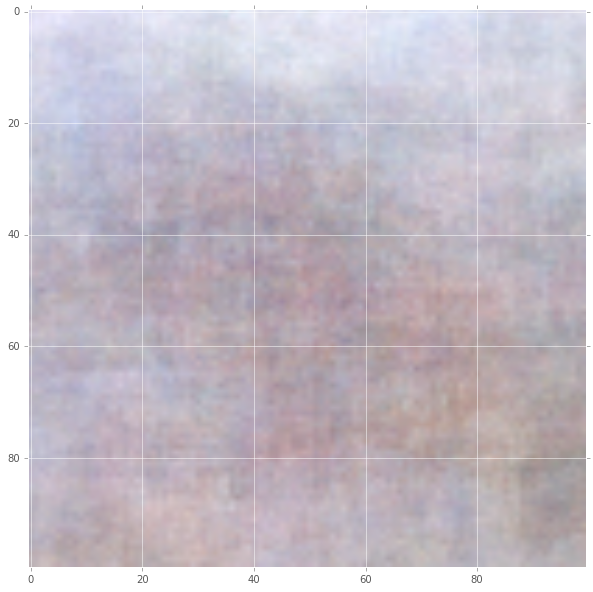

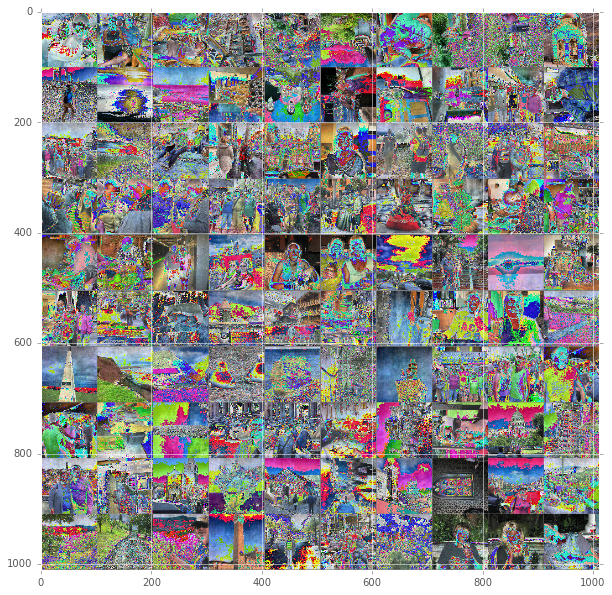

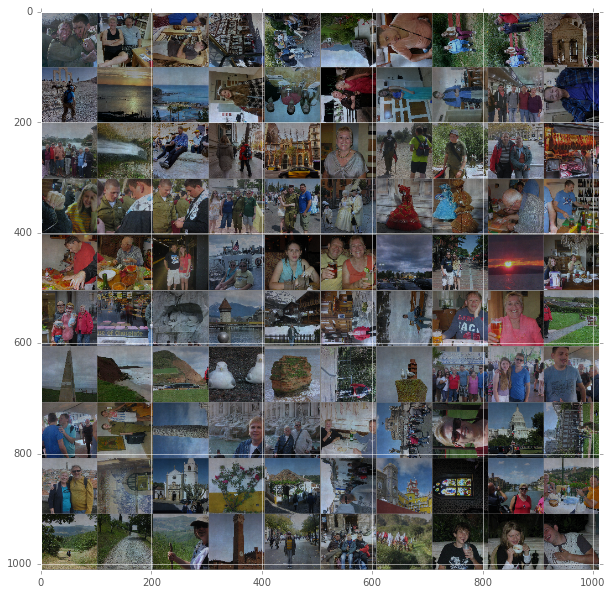

In [37]:
import tensorflow as tf
sess         = tf.InteractiveSession()

tf_imgs      = tf.constant(imgs)

# First method to get 4D mean tensor
tf_mean      = tf.reduce_mean(tf_imgs, 0) 
tf_mean_4d   = tf.expand_dims(tf_mean, 0) # 1 x H x W x C

# Second method to get 4D mean tensor
#tf_mean_4d   = tf.reduce_mean(imgs, reduction_indices=0, keep_dims=True)

# Standard deviation
substract    = tf_imgs - tf_mean_4d
tf_std       = tf.sqrt(tf.reduce_sum(substract * substract, reduction_indices=0))
tf_std_4d    = tf.expand_dims(tf_mean, 0) # 1 x H x W x C

# Normalize 
tf_norm      = tf.div(tf_imgs-tf_mean_4d,tf_std_4d)


mean_img     = sess.run(tf_mean)
plt.figure(figsize=(10, 10))
plt.imshow(mean_img)
print 'Shape of mean image: ',tf_mean.get_shape()
#plt.imsave(arr=mean_img, fname='mean.png')


std_img = sess.run(tf_std)
assert(std_img.shape == (100, 100) or std_img.shape == (100, 100, 3))
plt.figure(figsize=(10, 10))
std_img_show = std_img / np.max(std_img)
plt.imshow(std_img_show)
print 'Shape of std image: ',tf_std.get_shape()

norm_imgs = sess.run(tf_norm)
assert(std_img.shape == (100, 100) or std_img.shape == (100, 100, 3))
plt.figure(figsize=(10, 10))
plt.imshow(montage(norm_imgs, saveto='dataset.png'))
print 'Shape of normalized  images: ',tf_norm.get_shape()


# compare to 0-1 normalization
norm_imgs_show = (norm_imgs - np.min(norm_imgs)) / (np.max(norm_imgs) - np.min(norm_imgs))
plt.figure(figsize=(10, 10))
plt.imshow(montage(norm_imgs_show, 'normalized.png'))

# Same code using numpy
# plt.figure()
# mean_img = np.mean(imgs, axis=0)
# plt.figure()
# plt.imshow(mean_img)

In [31]:
def gauss(mean, stddev, ksize):
    """Uses Tensorflow to compute a Gaussian Kernel.
    Parameters
    ----------
    mean : float
        Mean of the Gaussian (e.g. 0.0).
    stddev : float
        Standard Deviation of the Gaussian (e.g. 1.0).
    ksize : int
        Size of kernel (e.g. 16).
    Returns
    -------
    kernel : np.ndarray
        Computed Gaussian Kernel using Tensorflow.
    """
    g = tf.Graph()
    with tf.Session(graph=g):
        x = tf.linspace(-3.0, 3.0, ksize)
        z = (tf.exp(tf.neg(tf.pow(x - mean, 2.0) /
                           (2.0 * tf.pow(stddev, 2.0)))) *
             (1.0 / (stddev * tf.sqrt(2.0 * 3.1415))))
        return z.eval()


def gauss2d(mean, stddev, ksize):
    """Uses Tensorflow to compute a 2D Gaussian Kernel.
    Parameters
    ----------
    mean : float
        Mean of the Gaussian (e.g. 0.0).
    stddev : float
        Standard Deviation of the Gaussian (e.g. 1.0).
    ksize : int
        Size of kernel (e.g. 16).
    Returns
    -------
    kernel : np.ndarray
        Computed 2D Gaussian Kernel using Tensorflow.
    """
    z = gauss(mean, stddev, ksize)
    g = tf.Graph()
    with tf.Session(graph=g):
        z_2d = tf.matmul(tf.reshape(z, [ksize, 1]), tf.reshape(z, [1, ksize]))
        return z_2d.eval()


def convolve(img, kernel):
    """Uses Tensorflow to convolve a 4D image with a 4D kernel.
    Parameters
    ----------
    img : np.ndarray
        4-dimensional image shaped N x H x W x C
    kernel : np.ndarray
        4-dimensional image shape K_H, K_W, C_I, C_O corresponding to the
        kernel's height and width, the number of input channels, and the
        number of output channels.  Note that C_I should = C.
    Returns
    -------
    result : np.ndarray
        Convolved result.
    """
    g = tf.Graph()
    with tf.Session(graph=g):
        convolved = tf.nn.conv2d(img, kernel, strides=[1, 1, 1, 1], padding='SAME')
        res = convolved.eval()
    return res


def gabor(ksize=32):
    """Uses Tensorflow to compute a 2D Gabor Kernel.
    Parameters
    ----------
    ksize : int, optional
        Size of kernel.
    Returns
    -------
    gabor : np.ndarray
        Gabor kernel with ksize x ksize dimensions.
    """
    g = tf.Graph()
    with tf.Session(graph=g):
        z_2d = gauss2d(0.0, 1.0, ksize)
        ones = tf.ones((1, ksize))
        ys = tf.sin(tf.linspace(-3.0, 3.0, ksize))
        ys = tf.reshape(ys, [ksize, 1])
        wave = tf.matmul(ys, ones)
        gabor = tf.mul(wave, z_2d)
        return gabor.eval()


<a name="Convolve-tensorflow"></a>
## Convolve images

3 concatinated gabor kernels of 4D shape:  (24, 24, 3, 1)
(100, 100, 100, 1)


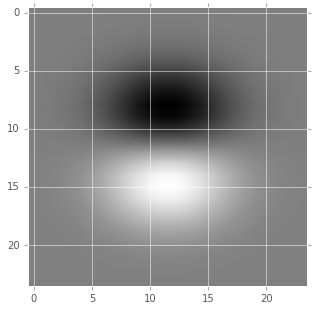

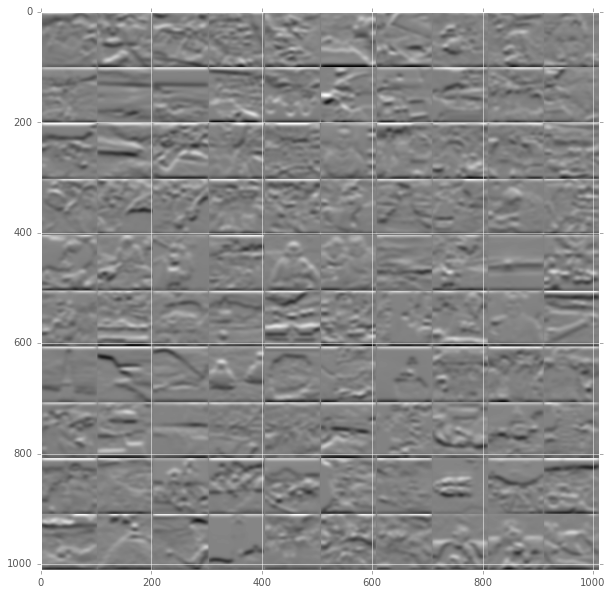

In [49]:
ksize     = 24
kernel    = np.concatenate([gabor(ksize)[:, :, np.newaxis] for i in range(3)], axis=2)
kernel_4d = kernel.reshape((kernel.shape[0],kernel.shape[1],kernel.shape[2],1))
print '3 concatinated gabor kernels of 4D shape: ',kernel_4d.shape

plt.figure(figsize=(5, 5))
plt.imshow(kernel_4d[:, :, 0, 0], cmap='gray')

# convolve
convolved = convolve(imgs,kernel_4d)
convolved_show = (convolved - np.min(convolved)) / (np.max(convolved) - np.min(convolved))
print(convolved_show.shape)
plt.figure(figsize=(10, 10))
plt.imshow(montage(convolved_show[..., 0], 'convolved.png'), cmap='gray')

<a name="Sort-tensorflow"></a>
## Sort  images

Got 100 mean values


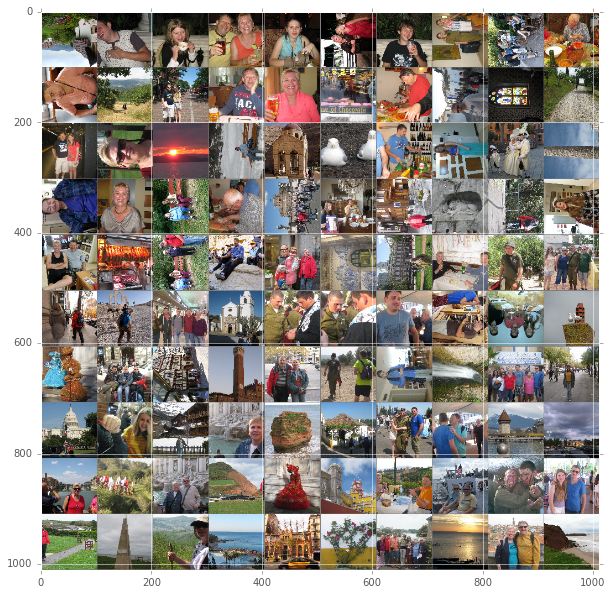

In [63]:
k = convolved.shape[1]*convolved.shape[2]*convolved.shape[3]
flattened = tf.reshape(convolved,(convolved.shape[0],k))
assert(flattened.get_shape().as_list() == [100, 10000])

values = tf.reduce_sum(flattened, reduction_indices=1)  # Compute mean of response for each image 
print 'Got {} mean values'.format(values.get_shape()[0])

# Get sorted indices
idxs_op     = tf.nn.top_k(values, k=100)[1]
idxs        = sess.run(idxs_op)
sorted_imgs = np.array([imgs[idx_i] for idx_i in idxs]) # sort th eimages

assert(sorted_imgs.shape == (100, 100, 100, 3))
plt.figure(figsize=(10, 10))
plt.imshow(montage(sorted_imgs, 'sorted.png'))
